# Import & Download required libraries

In [3]:
!pip install wordcloud
!pip install seaborn

In [4]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,GlobalAveragePooling2D, Dense, Dropout, LSTM, Bidirectional

In [53]:
# Download helper function
!wget https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py

--2023-09-16 22:46:23--  https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-16 22:46:23 (54.5 MB/s) - ‘helper_function.py’ saved [10246/10246]



In [55]:
# Import series of helper functions for the notebook
from helper_function import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [6]:
url = 'https://raw.githubusercontent.com/SNNJM/TF_DL_SkillsChecklist/main/4_NLP/dataset/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [9]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [10]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

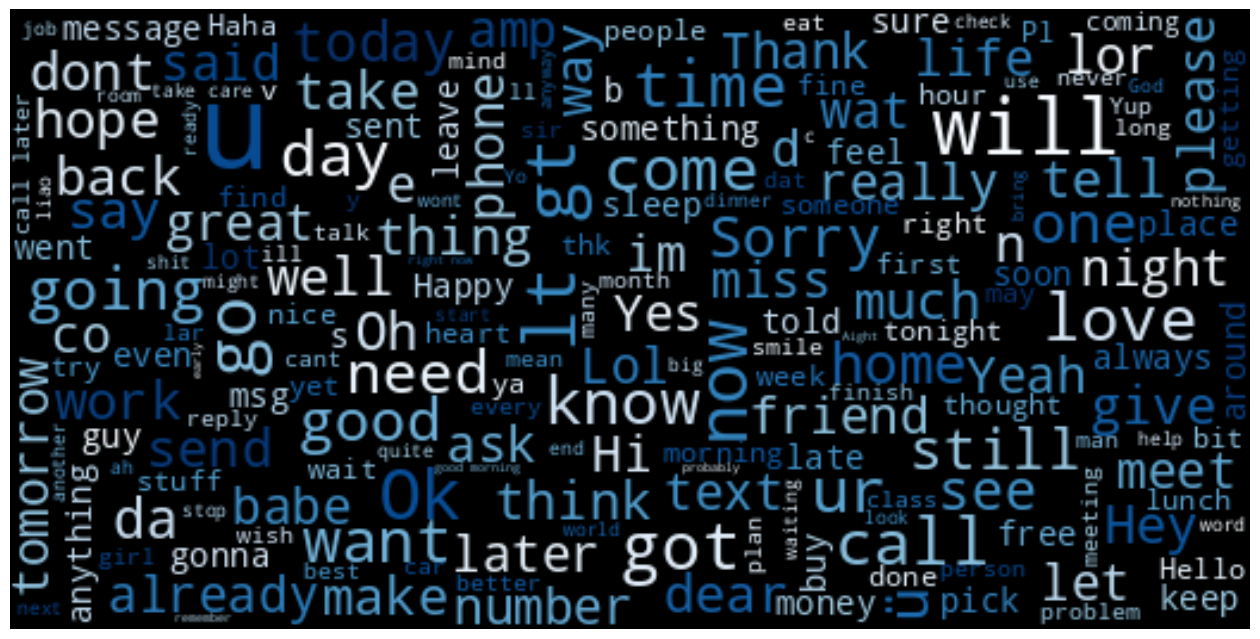

In [11]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

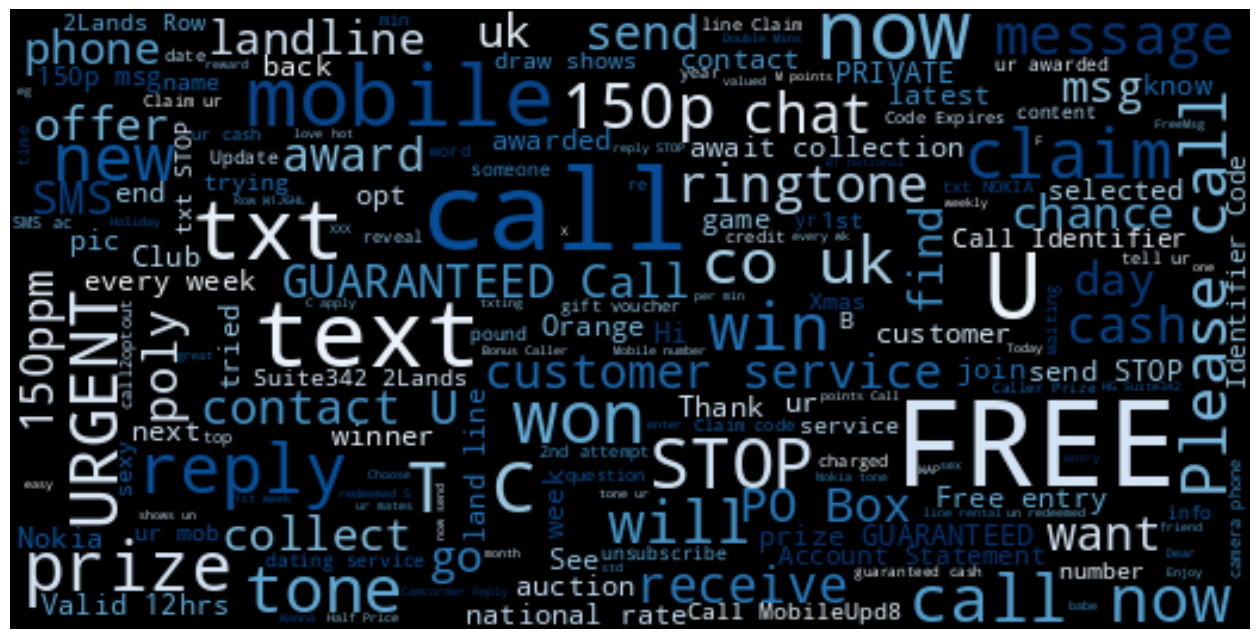

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

sns.countplot(data=df, x="class", hue="alive")

https://seaborn.pydata.org/generated/seaborn.countplot.html

15.481865284974095

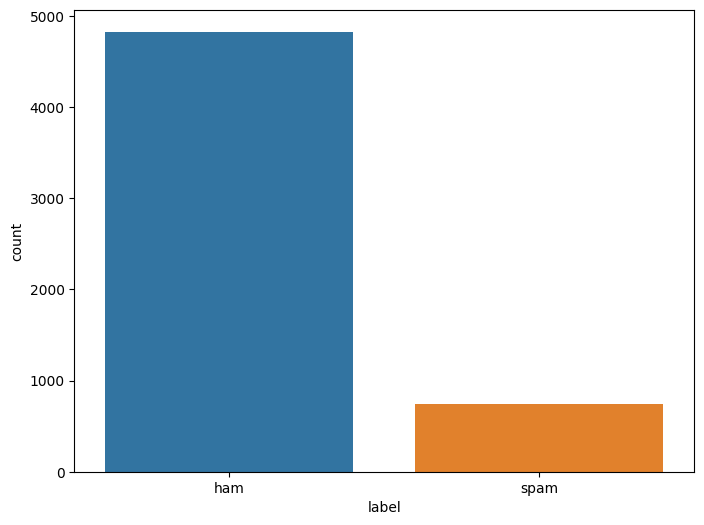

In [13]:
# we can observe imbalance data here
plt.figure(figsize=(8,6))
sns.countplot(data=messages,x="label")
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [14]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


<ipython-input-15-3fb4c7456faf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


Text(0.5, 0, 'Message types')

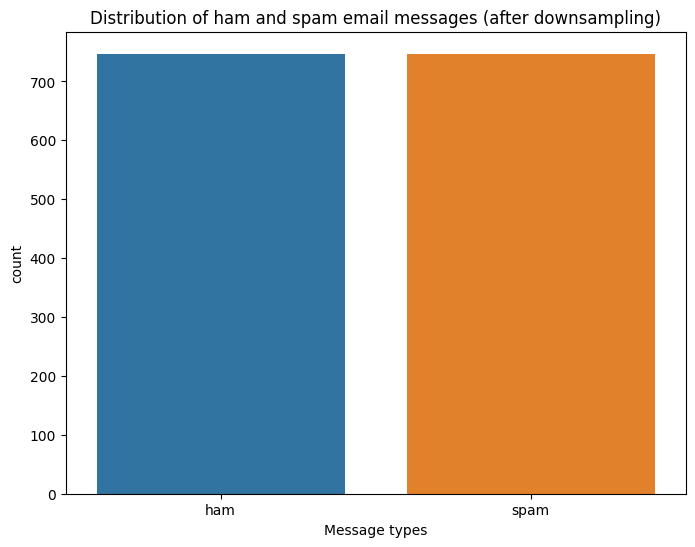

In [15]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(data=msg_df,x="label")
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [16]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

<ipython-input-16-f3712e9df1c5>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
ham,73.238286
spam,138.670683


In [17]:
#Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [18]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

In [19]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [20]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [21]:
# check how many words
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [22]:
# Sequencing and padding on training and testing
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [23]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [24]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [25]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [26]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [27]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

# Model Creation

## Baseline model

In [29]:
#Create model
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

#Compile model
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

# Fit model
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6852 - accuracy: 0.6828 - val_loss: 0.6760 - val_accuracy: 0.6923 - 2s/epoch - 40ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6614 - accuracy: 0.7916 - val_loss: 0.6399 - val_accuracy: 0.8127 - 134ms/epoch - 4ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6099 - accuracy: 0.8502 - val_loss: 0.5755 - val_accuracy: 0.8294 - 144ms/epoch - 4ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5284 - accuracy: 0.8695 - val_loss: 0.4927 - val_accuracy: 0.8629 - 127ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4358 - accuracy: 0.8895 - val_loss: 0.4144 - val_accuracy: 0.8629 - 121ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3582 - accuracy: 0.8954 - val_loss: 0.3521 - val_accuracy: 0.8796 - 127ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2966 - accuracy: 0.9079 - val_loss: 0.3033 - val_accuracy: 0.8863 - 114ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2545 - accuracy: 0.9188 - val_loss: 0.2643 - val_accuracy: 0.8930 - 119ms/epoch - 3ms/step
Epoch 9/30
38/38 -

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [31]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# Model performance on test data
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9532


[0.11808973550796509, 0.953177273273468]

## Long Short Term Memory (LSTM) Model

In [37]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

add
model.add(Flatten())
OR
model.add(GlobalAveragePooling2D())

to match the output with the dimension of the label by adding a Flatten layer after the Dense layer:

https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape

In [38]:
#Cteate LSTM Spam detection model
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))
model1.add(GlobalAveragePooling1D())

#Compile model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


# Fit model

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history1 = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 9s - loss: 0.6477 - accuracy: 0.7130 - val_loss: 0.5247 - val_accuracy: 0.7960 - 9s/epoch - 225ms/step
Epoch 2/30
38/38 - 2s - loss: 0.3454 - accuracy: 0.8895 - val_loss: 0.2726 - val_accuracy: 0.9130 - 2s/epoch - 43ms/step
Epoch 3/30
38/38 - 2s - loss: 0.2271 - accuracy: 0.9339 - val_loss: 0.2649 - val_accuracy: 0.9130 - 2s/epoch - 44ms/step
Epoch 4/30
38/38 - 2s - loss: 0.1788 - accuracy: 0.9540 - val_loss: 0.2075 - val_accuracy: 0.9298 - 2s/epoch - 42ms/step
Epoch 5/30
38/38 - 2s - loss: 0.1584 - accuracy: 0.9640 - val_loss: 0.1974 - val_accuracy: 0.9331 - 2s/epoch - 45ms/step
Epoch 6/30
38/38 - 2s - loss: 0.1316 - accuracy: 0.9724 - val_loss: 0.2196 - val_accuracy: 0.9331 - 2s/epoch - 45ms/step
Epoch 7/30
38/38 - 2s - loss: 0.1284 - accuracy: 0.9724 - val_loss: 0.1894 - val_accuracy: 0.9365 - 2s/epoch - 53ms/step
Epoch 8/30
38/38 - 2s - loss: 0.1146 - accuracy: 0.9732 - val_loss: 0.2057 - val_accuracy: 0.9398 - 2s/epoch - 62ms/step
Epoch 9/30
38/38 - 2s - loss: 0

In [62]:
# Model performance on test data
model1.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 28ms/step - loss: 0.1596 - accuracy: 0.9565


[0.1595509797334671, 0.95652174949646]

In [39]:
model1.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Bi-directional Long Short Term Memory (BiLSTM) Model

In [41]:
# Create Biderectional LSTM Spam detection model
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))
model2.add(GlobalAveragePooling1D())

# Compile model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Fit model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history2 = model2.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 8s - loss: 0.6854 - accuracy: 0.5146 - val_loss: 0.6542 - val_accuracy: 0.7592 - 8s/epoch - 221ms/step
Epoch 2/30
38/38 - 1s - loss: 0.4865 - accuracy: 0.8803 - val_loss: 0.3187 - val_accuracy: 0.9130 - 1s/epoch - 36ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2648 - accuracy: 0.9188 - val_loss: 0.2574 - val_accuracy: 0.9164 - 1s/epoch - 37ms/step
Epoch 4/30
38/38 - 1s - loss: 0.2359 - accuracy: 0.9096 - val_loss: 0.2122 - val_accuracy: 0.9130 - 1s/epoch - 36ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1718 - accuracy: 0.9372 - val_loss: 0.1729 - val_accuracy: 0.9298 - 1s/epoch - 36ms/step
Epoch 6/30
38/38 - 3s - loss: 0.1369 - accuracy: 0.9515 - val_loss: 0.1445 - val_accuracy: 0.9298 - 3s/epoch - 68ms/step
Epoch 7/30
38/38 - 1s - loss: 0.1234 - accuracy: 0.9565 - val_loss: 0.1372 - val_accuracy: 0.9398 - 1s/epoch - 36ms/step
Epoch 8/30
38/38 - 1s - loss: 0.1040 - accuracy: 0.9607 - val_loss: 0.1279 - val_accuracy: 0.9498 - 1s/epoch - 36ms/step
Epoch 9/30
38/38 - 1s - loss: 0

In [63]:
# Model performance on test data
model2.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 10ms/step - loss: 0.1754 - accuracy: 0.9498


[0.1754404455423355, 0.9498327970504761]

In [42]:
model2.save("model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9532
Dense architecture loss and accuracy: [0.11808973550796509, 0.953177273273468] 
10/10 [==============================] - 0s 11ms/step - loss: 0.1596 - accuracy: 0.9565
LSTM architecture loss and accuracy: [0.1595509797334671, 0.95652174949646] 
10/10 [==============================] - 0s 10ms/step - loss: 0.1754 - accuracy: 0.9498
Bi-LSTM architecture loss and accuracy: [0.1754404455423355, 0.9498327970504761] 


# Predict spam/ham on new messages

## Test 1: Use raw text from our data:

In [45]:
# display long string
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [46]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [47]:
# Defining prediction functiondef predict_spam(predict_msg):
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

predict_spam(predict_msg)

1/1 [==============================] - 0s 105ms/step


array([[0.01776317],
       [0.00773769],
       [0.999319  ]], dtype=float32)

## Test 2: Use newly created text message and see how the model classifies them.

In [48]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 24ms/step


array([[0.8639135 ],
       [0.0414031 ],
       [0.01835335]], dtype=float32)

Our model correctly classifies the first message as spam (92% chance to be spam) were as the rest as ham.

# Add RNN

In [49]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import SimpleRNN

#Cteate LSTM Spam detection model with RNN
model3 = Sequential()
model3.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model3.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model3.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model3.add(layers.SimpleRNN(64))
model3.add(Dense(1, activation='sigmoid'))
#model3.add(GlobalAveragePooling2D())

#Compile model
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


# Fit model

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history3 = model3.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 21s - loss: 0.5004 - accuracy: 0.7682 - val_loss: 0.5020 - val_accuracy: 0.7960 - 21s/epoch - 553ms/step
Epoch 2/30
38/38 - 4s - loss: 0.2823 - accuracy: 0.9079 - val_loss: 0.2402 - val_accuracy: 0.9298 - 4s/epoch - 96ms/step
Epoch 3/30
38/38 - 3s - loss: 0.2315 - accuracy: 0.9264 - val_loss: 0.1737 - val_accuracy: 0.9365 - 3s/epoch - 66ms/step
Epoch 4/30
38/38 - 3s - loss: 0.1669 - accuracy: 0.9531 - val_loss: 0.1144 - val_accuracy: 0.9666 - 3s/epoch - 81ms/step
Epoch 5/30
38/38 - 2s - loss: 0.1391 - accuracy: 0.9607 - val_loss: 0.1567 - val_accuracy: 0.9565 - 2s/epoch - 52ms/step
Epoch 6/30
38/38 - 2s - loss: 0.1355 - accuracy: 0.9607 - val_loss: 0.2540 - val_accuracy: 0.9130 - 2s/epoch - 53ms/step


In [64]:
# Model performance on test data
model3.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 23ms/step - loss: 0.2540 - accuracy: 0.9130


[0.25399380922317505, 0.9130434989929199]

In [50]:
model3.save("mpdel3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Add GRU


In [51]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import GRU

#Cteate LSTM Spam detection model with RNN
model4 = Sequential()
model4.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model4.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model4.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model4.add(layers.GRU(64, return_sequences=True))
model4.add(layers.SimpleRNN(64))
model4.add(Dense(1, activation='sigmoid'))
#model3.add(GlobalAveragePooling2D())

#Compile model
model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


# Fit model

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history4 = model4.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 17s - loss: 0.5021 - accuracy: 0.7774 - val_loss: 0.4191 - val_accuracy: 0.8462 - 17s/epoch - 459ms/step
Epoch 2/30
38/38 - 4s - loss: 0.3093 - accuracy: 0.8862 - val_loss: 0.2828 - val_accuracy: 0.8963 - 4s/epoch - 99ms/step
Epoch 3/30
38/38 - 3s - loss: 0.1694 - accuracy: 0.9456 - val_loss: 0.1347 - val_accuracy: 0.9498 - 3s/epoch - 81ms/step
Epoch 4/30
38/38 - 3s - loss: 0.1283 - accuracy: 0.9598 - val_loss: 0.1256 - val_accuracy: 0.9599 - 3s/epoch - 82ms/step
Epoch 5/30
38/38 - 4s - loss: 0.1050 - accuracy: 0.9690 - val_loss: 0.1547 - val_accuracy: 0.9398 - 4s/epoch - 97ms/step
Epoch 6/30
38/38 - 3s - loss: 0.0905 - accuracy: 0.9741 - val_loss: 0.2059 - val_accuracy: 0.9431 - 3s/epoch - 88ms/step


In [65]:
# Model performance on test data
model4.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 35ms/step - loss: 0.2059 - accuracy: 0.9431


[0.20590128004550934, 0.9431437849998474]

In [52]:
model4.save("model4.h5")

# Plot Loss & acc curve

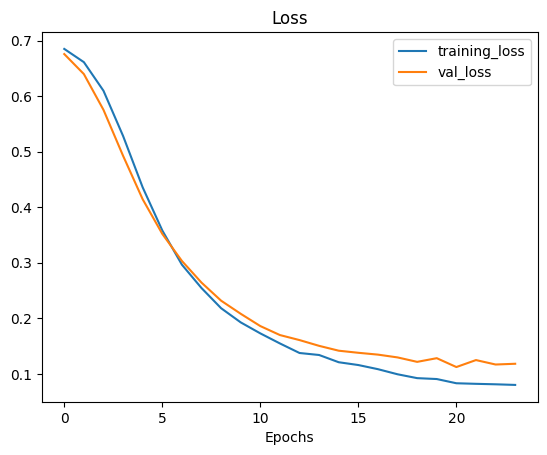

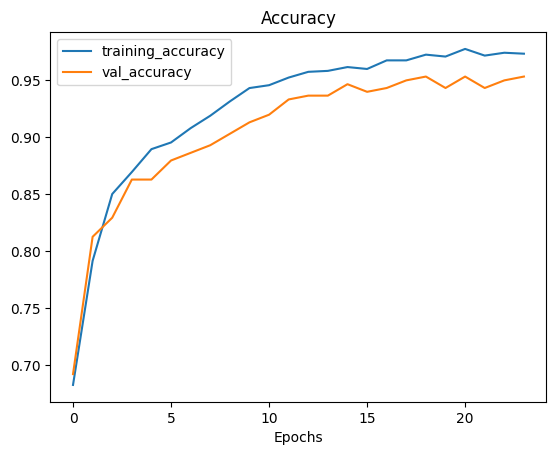

In [57]:
# Check out the loss & accuracy curves of baselina model
plot_loss_curves(history)

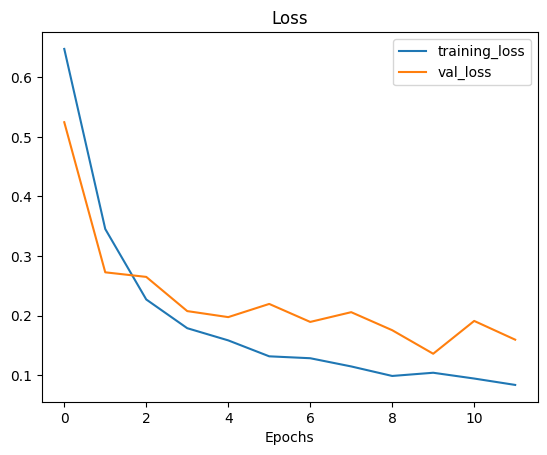

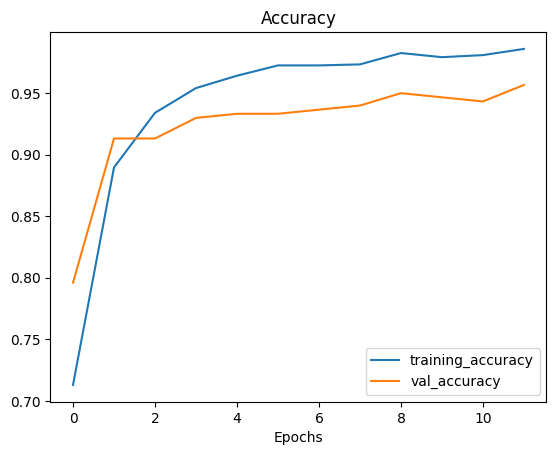

In [58]:
# Check out the loss & accuracy curves of LSTM model
plot_loss_curves(history1)

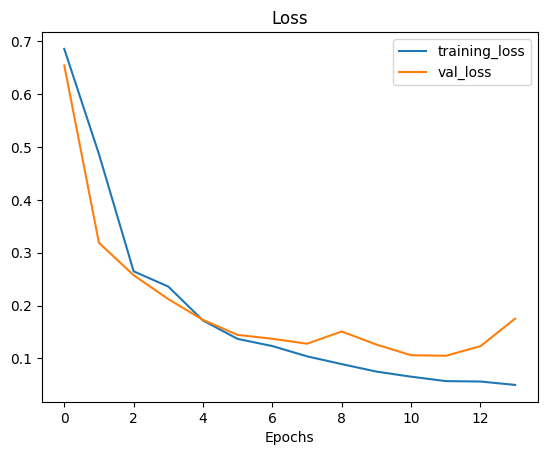

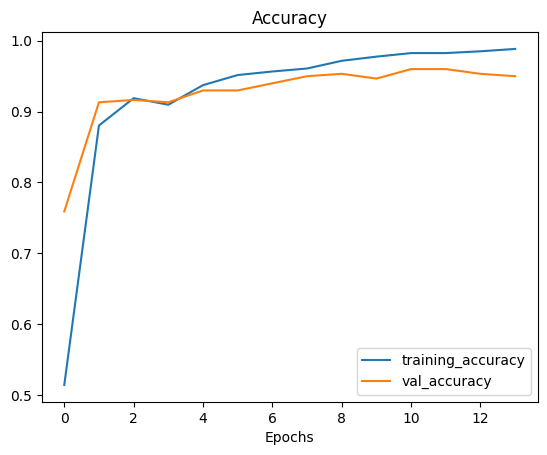

In [59]:
# Check out the loss & accuracy curves of biLSTM model
plot_loss_curves(history2)

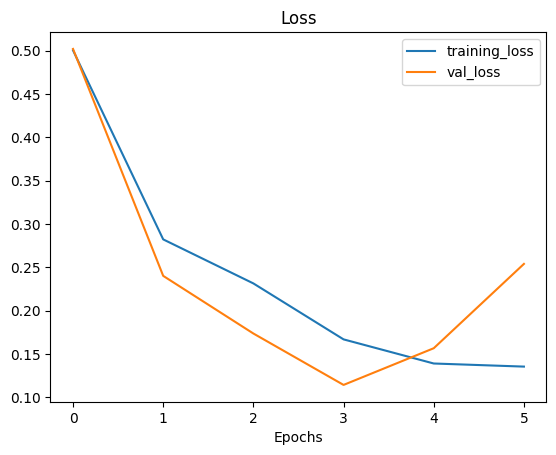

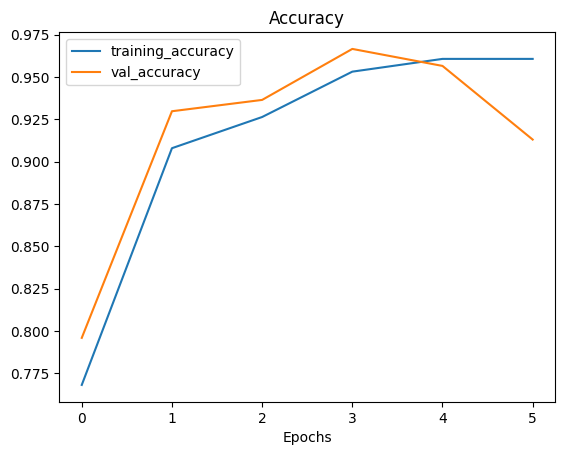

In [60]:
# Check out the loss & accuracy curves of RNN model
plot_loss_curves(history3)

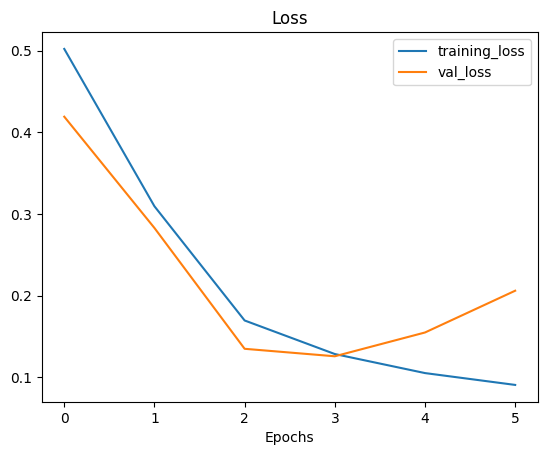

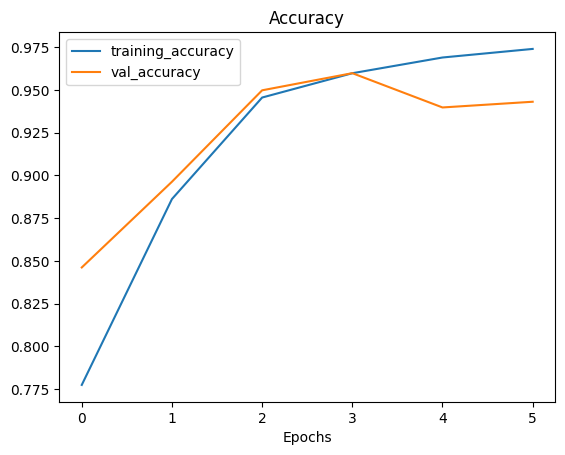

In [61]:
# Check out the loss & accuracy curves of GRU model
plot_loss_curves(history4)